## **Project Overview: Cluster Analysis for GHG Emission Profiles of Vehicles**  

This project aims to analyze and categorize vehicles based on their **greenhouse gas (GHG) emission profiles** using **clustering techniques**. With transportation being a major contributor to global CO₂ emissions, understanding emission patterns is crucial for **policy development, sustainable manufacturing, and informed consumer choices**.  

### **Objectives:**  
- Identify **distinct groups of vehicles** based on emission levels and fuel efficiency.  
- Compare different **clustering algorithms** to determine the most effective approach.  
- Provide **data-driven insights** for policymakers, manufacturers, and consumers to promote **low-emission vehicle adoption** and compliance with **environmental regulations**.  

### **Impact & Expected Outcomes**  
The insights from this study will:  
- Guide **policymakers** in developing **data-driven emissions regulations**.  
- Assist **manufacturers** in optimizing vehicle designs for improved fuel efficiency.  
- Help **consumers** choose environmentally friendly vehicles.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
# Load dataset
emission_df = pd.read_csv('../datasets/vehicle_emissions.csv')  
emission_df.head()

Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   
2                              5.8                               5.9   
3                              9.1                              11.1   
4                              8.7                              10.6   

   Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  
0                           33                  196  
1                           29                  221  
2                           48                  136  
3                           25                  255  
4                           27                  244

In [3]:
print(emission_df.shape)

(7385, 12)


### **Data Preparation**  
To ensure the accuracy and efficiency of the clustering models, the following steps are performed:  

1. **Data Collection:**  
   - Sources include **Kaggle**,  **EPA emissions databases**, **vehicle fuel efficiency reports**, and **manufacturer datasets**.
       

2. **Data Cleaning & Preprocessing:**  
   - **Handling missing values** through imputation or removal.  
   - **Feature selection** to retain relevant attributes such as **CO₂ emissions, fuel type, engine size, and fuel efficiency**.  
   - **Normalization/scaling** of numerical variables to improve clustering performance.  
   - **Encoding categorical variables** (e.g., fuel type, transmission).  


In [4]:
# Check for missing values
print(emission_df.isnull().sum())

Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64


In [5]:
# Drop unnecessary columns
emission_data = emission_df.drop(columns=['Make', 'Model'])

# One-hot encode categorical variables
cat_cols = ['Vehicle Class', 'Transmission', 'Fuel Type']
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_transformed = one_hot_encoder.fit_transform(emission_data[cat_cols])
categorical_df = pd.DataFrame(categorical_transformed, columns=one_hot_encoder.get_feature_names_out(cat_cols))
emission_data = emission_data.drop(columns=cat_cols).reset_index(drop=True)
emission_data = pd.concat([emission_data, categorical_df], axis=1)

In [6]:
emission_data.head()

Engine Size(L)  Cylinders  Fuel Consumption City (L/100 km)  \
0             2.0          4                               9.9   
1             2.4          4                              11.2   
2             1.5          4                               6.0   
3             3.5          6                              12.7   
4             3.5          6                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   
2                              5.8                               5.9   
3                              9.1                              11.1   
4                              8.7                              10.6   

   Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  Vehicle Class_FULL-SIZE  \
0                           33                  196                      0.0   
1                           29                  221                      0.0   
2                           48                  136                      0.0   
3                           25                  255                      0.0   
4                           27                  244                      0.0   

   Vehicle Class_MID-SIZE  Vehicle Class_MINICOMPACT  ...  Transmission_AV6  \
0                     0.0                        0.0  ...               0.0   
1                     0.0                        0.0  ...               0.0   
2                     0.0                        0.0  ...               0.0   
3                     0.0                        0.0  ...               0.0   
4                     0.0                        0.0  ...               0.0   

   Transmission_AV7  Transmission_AV8  Transmission_M5  Transmission_M6  \
0               0.0               0.0              0.0              0.0   
1               0.0               0.0              0.0              1.0   
2               1.0               0.0              0.0              0.0   
3               0.0               0.0              0.0              0.0   
4               0.0               0.0              0.0              0.0   

   Transmission_M7  Fuel Type_E  Fuel Type_N  Fuel Type_X  Fuel Type_Z  
0              0.0          0.0          0.0          0.0          1.0  
1              0.0          0.0          0.0          0.0          1.0  
2              0.0          0.0          0.0          0.0          1.0  
3              0.0          0.0          0.0          0.0          1.0  
4              0.0          0.0          0.0          0.0          1.0  

[5 rows x 52 columns]

In [7]:
# Feature Engineering
emission_data['Fuel Consumption Ratio'] = emission_data['Fuel Consumption City (L/100 km)'] / emission_data['Fuel Consumption Hwy (L/100 km)']
emission_data['CO2 Efficiency'] = emission_data['CO2 Emissions(g/km)'] / emission_data['Fuel Consumption Comb (L/100 km)']

In [8]:
# Standardize features
scaler = StandardScaler()
scaled_features = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb (L/100 km)', 'CO2 Emissions(g/km)',
                   'Fuel Consumption Ratio', 'CO2 Efficiency']
emission_data[scaled_features] = scaler.fit_transform(emission_data[scaled_features])

In [9]:
# Detect Outliers & Removal 
z_scores = np.abs(zscore(emission_data[scaled_features]))
emission_data = emission_data[(z_scores < 3).all(axis=1)]

In [10]:
# Select variable for Corr
selected_df = emission_data[['Engine Size(L)','Cylinders', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)']]
selected_df.head()

Engine Size(L)  Cylinders  Fuel Consumption City (L/100 km)  \
0       -0.856721  -0.883408                               9.9   
1       -0.561317  -0.883408                              11.2   
2       -1.225976  -0.883408                               6.0   
3        0.251043   0.210575                              12.7   
4        0.251043   0.210575                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                         -0.855742   
1                              7.7                         -0.475423   
2                              5.8                         -1.754677   
3                              9.1                          0.043193   
4                              8.7                         -0.129679   

   Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  
0                           33            -0.932933  
1                           29            -0.505646  
2                           48            -1.958421  
3                           25             0.075464  
4                           27            -0.112542

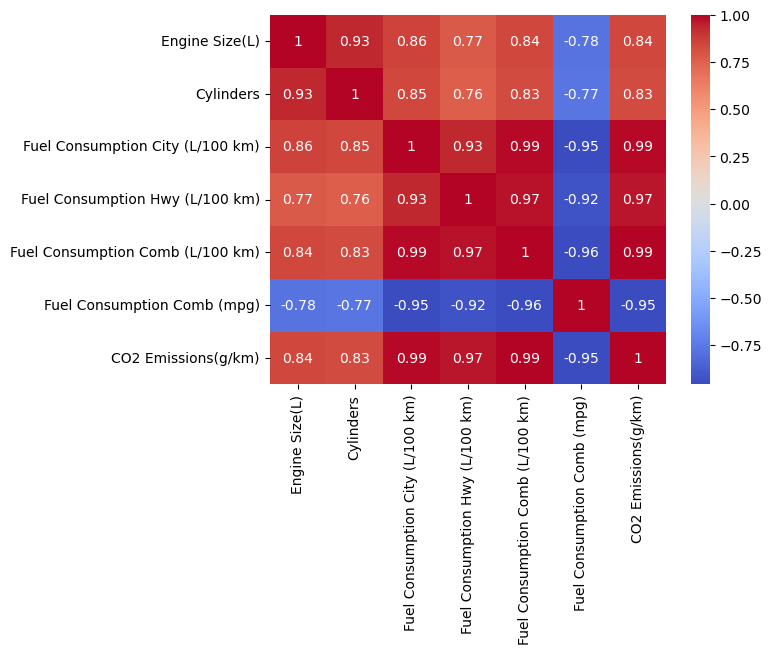

In [11]:
# Create a heatmap to show the correlation between features
correlation_matrix = selected_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=90)
plt.show()

In [37]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=3) 
pca_features = pca.fit_transform(emission_data[scaled_features])
emission_data['PCA1'], emission_data['PCA2'], emission_data['PCA3'] = pca_features[:, 0], pca_features[:, 1], pca_features[:, 2]

In [13]:
# Fetch the explained variance
sum(list(pca.explained_variance_ratio_))

0.9497530188867449

In [14]:
# Transform PCA data to a DataFrame
emission_data_pca = pd.DataFrame(
    data=pca_features,
    columns=["principal component 1", "principal component 2", "principal component 3"],
)
emission_data_pca.head()

principal component 1  principal component 2  principal component 3
0              -1.298578               1.151532              -0.150156
1              -0.818095               0.779821              -0.356597
2              -3.340835              -1.675083               1.199626
3               0.505492               0.005274               0.148797
4               0.326428               0.051113               0.330372

In [15]:
pca.explained_variance_ratio_

array([0.74551694, 0.15079933, 0.05343675])

### **Modeling Approach**  
1. **Clustering Techniques Applied:**  
   - **K-Means Clustering** for segmenting vehicles based on emission levels.  
   - **Hierarchical Clustering** to explore relationships between vehicle types.  
   - **DBSCAN** for identifying outliers, such as extreme polluters or ultra-low-emission vehicles.  

2. **Model Evaluation & Interpretation:**  
   - **Silhouette Score** and **Elbow Method** to determine the optimal number of clusters.  
   - **Visualization of clusters** using **scatter plots, heatmaps, and PCA (Principal Component Analysis)** for dimensionality reduction.  
   - **Comparison of clustering algorithms** based on cluster compactness and separation.  

## i.	K-Means Clustering

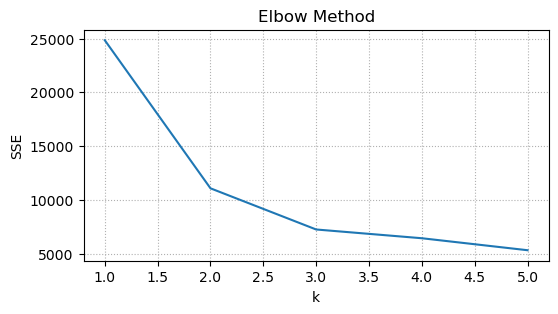

In [16]:
sse = {}
K = range(1,6)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(emission_data_pca)
    sse[k]= kmeans.inertia_
    
# Plot
plt.figure(figsize=(6, 3))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('k')
plt.ylabel('SSE')
plt.grid(True, linestyle=':')
plt.title('Elbow Method')
plt.show()

In [17]:
# Initialize the K-Means model
model = KMeans(n_clusters=3, random_state=0)

# Fit the model
model.fit(emission_data_pca)

# Predict clusters
predictions = model.predict(emission_data_pca)

In [18]:
# Add the predicted class columns
emission_data_pca["class"] = predictions
emission_data_pca.head()

principal component 1  principal component 2  principal component 3  class
0              -1.298578               1.151532              -0.150156      0
1              -0.818095               0.779821              -0.356597      0
2              -3.340835              -1.675083               1.199626      0
3               0.505492               0.005274               0.148797      1
4               0.326428               0.051113               0.330372      1

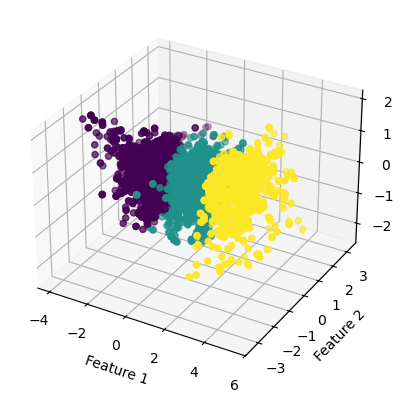

In [19]:
# create a 3D scatter plot to visualize the separation between clusters.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(emission_data_pca['principal component 1'], 
           emission_data_pca['principal component 2'], 
           emission_data_pca['principal component 3'], 
           c=emission_data_pca["class"], cmap='viridis')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()

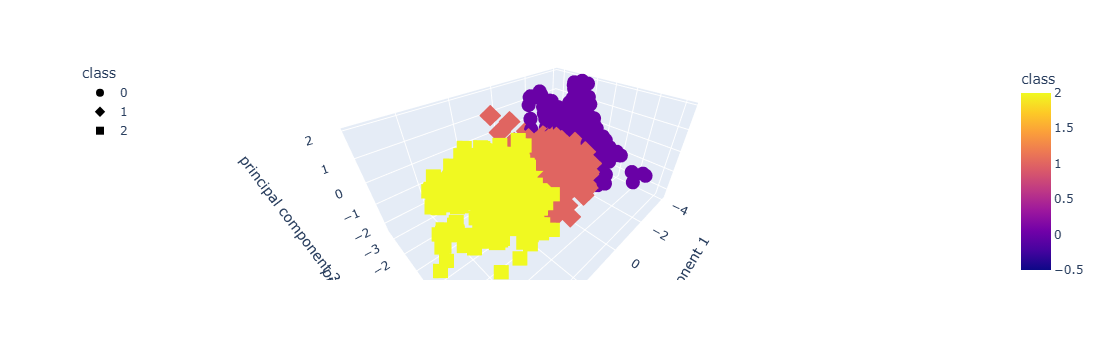

In [20]:
# plot the 3 principal components
import plotly.express as px
fig = px.scatter_3d(
    emission_data_pca,
    x='principal component 1',
    y='principal component 2',
    z='principal component 3',
    color="class",
    symbol="class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [38]:
# predictions
emission_data_class= emission_data
emission_data_class["class"] = predictions

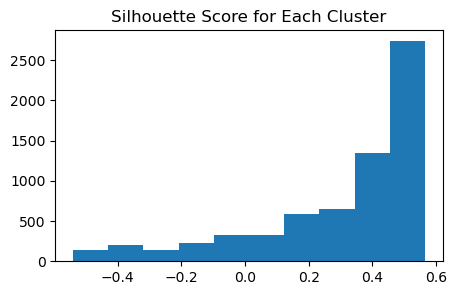

In [39]:
# plot silhouette score to assess the quality of the clustering
plt.figure(figsize=(5, 3))
silhouette_values = silhouette_samples(emission_data_class, emission_data_class['class'])
plt.hist(silhouette_values, bins=10)
plt.title('Silhouette Score for Each Cluster')
plt.show()


In [23]:
print(f"Length of predictions: {len(predictions)}")
print(f"Length of emission_df: {len(emission_df)}")

Length of predictions: 6704
Length of emission_df: 7385


In [24]:
# Match emission_df rows present in emission_data
emission_df = emission_df.loc[emission_data.index].copy()

# Add the predicted clusters
emission_df["class"] = predictions
emission_df.head()

Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   
2                              5.8                               5.9   
3                              9.1                              11.1   
4                              8.7                              10.6   

   Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  class  
0                           33                  196      0  
1                           29                  221      0  
2                           48                  136      0  
3                           25                  255      1  
4                           27                  244      1

In [26]:
# Count vehicles per brand in each cluster
brand_cluster_distribution = emission_df.groupby(['Make', 'class']).size().unstack().fillna(0)

([<matplotlib.axis.XTick at 0x2038b672140>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

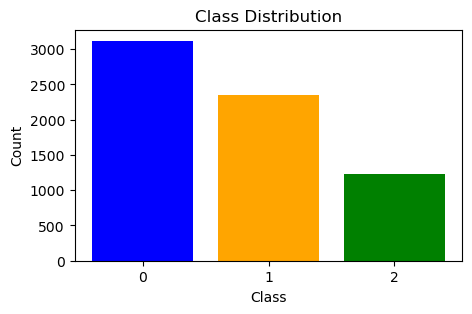

In [40]:
# Count of clusters
brand_cluster_count = emission_df.groupby(['class']).size()

# Creating a df to brand_cluster_count
brand_cluster_count = pd.DataFrame({'count': [3121, 2357, 1226]}, index=[0, 1, 2])
brand_cluster_count.index.name = 'class'

# Plotting the bar chart
plt.figure(figsize=(5, 3))
plt.bar(brand_cluster_count.index, brand_cluster_count['count'], color=['blue', 'orange', 'green'])

# Labels and title
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(brand_cluster_count.index)

In [27]:
# Convert to DataFrame
df_brand_cluster = brand_cluster_distribution.reset_index()

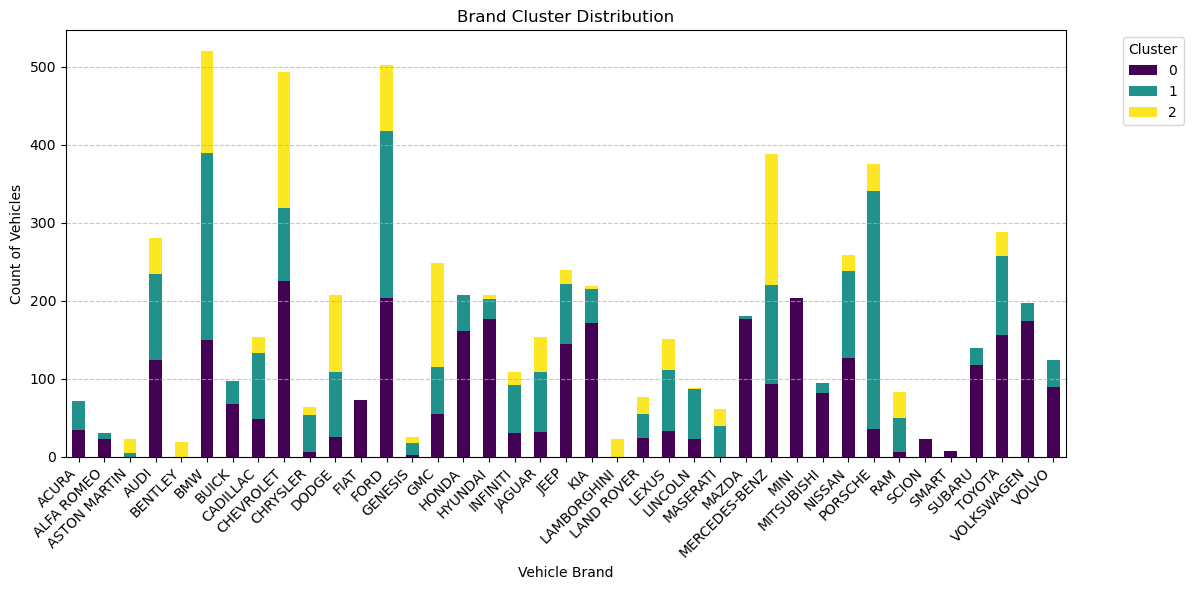

In [42]:
# Plot the brand cluster distribution
df_brand_cluster.set_index('Make').plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")

# Customize the plot
plt.title("Brand Cluster Distribution")
plt.xlabel("Vehicle Brand")
plt.ylabel("Count of Vehicles")
plt.xticks(rotation=45, ha="right")  
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [69]:
# mean values of fuel consumption and CO₂ emissions for each cluster
cluster_means = emission_df.groupby('class')[['Fuel Consumption City (L/100 km)', 'CO2 Emissions(g/km)']].mean()
print(cluster_means)

       Fuel Consumption City (L/100 km)  CO2 Emissions(g/km)
class                                                       
0                              9.833771           204.430952
1                             12.956003           264.611795
2                             16.141843           323.116639


In [28]:
# Compute average emissions per brand per cluster
emission_summary = emission_df.groupby(['Make', 'class'])[['Fuel Consumption City (L/100 km)', 'CO2 Emissions(g/km)']].mean().unstack()

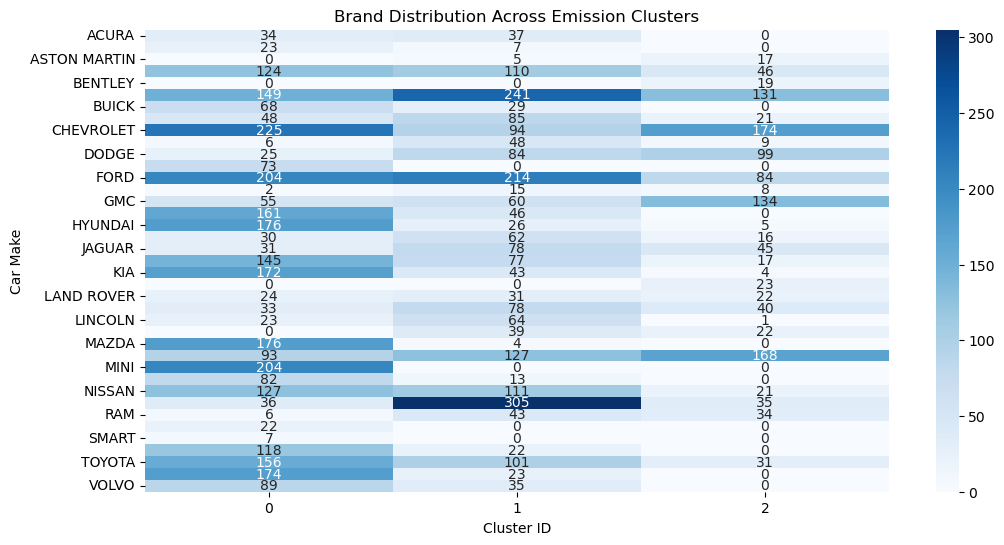

In [29]:
# Create heatmap to visualize which brands dominate each emission cluster 
plt.figure(figsize=(12, 6))
sns.heatmap(brand_cluster_distribution, cmap="Blues", annot=True, fmt=".0f")
plt.title("Brand Distribution Across Emission Clusters")
plt.xlabel("Cluster ID")
plt.ylabel("Car Make")
plt.show()

##  ii.	Hierarchical Clustering

In [30]:
# Perform hierarchical clustering
hierarchical = linkage(emission_data_pca, method='ward')
hierarchical_labels = fcluster(hierarchical, 3, criterion='maxclust')

In [31]:
hierarchical[:5]

array([[5.060e+02, 1.939e+03, 0.000e+00, 2.000e+00],
       [1.943e+03, 6.704e+03, 0.000e+00, 3.000e+00],
       [1.948e+03, 6.705e+03, 0.000e+00, 4.000e+00],
       [3.158e+03, 3.159e+03, 0.000e+00, 2.000e+00],
       [3.357e+03, 6.707e+03, 0.000e+00, 3.000e+00]])

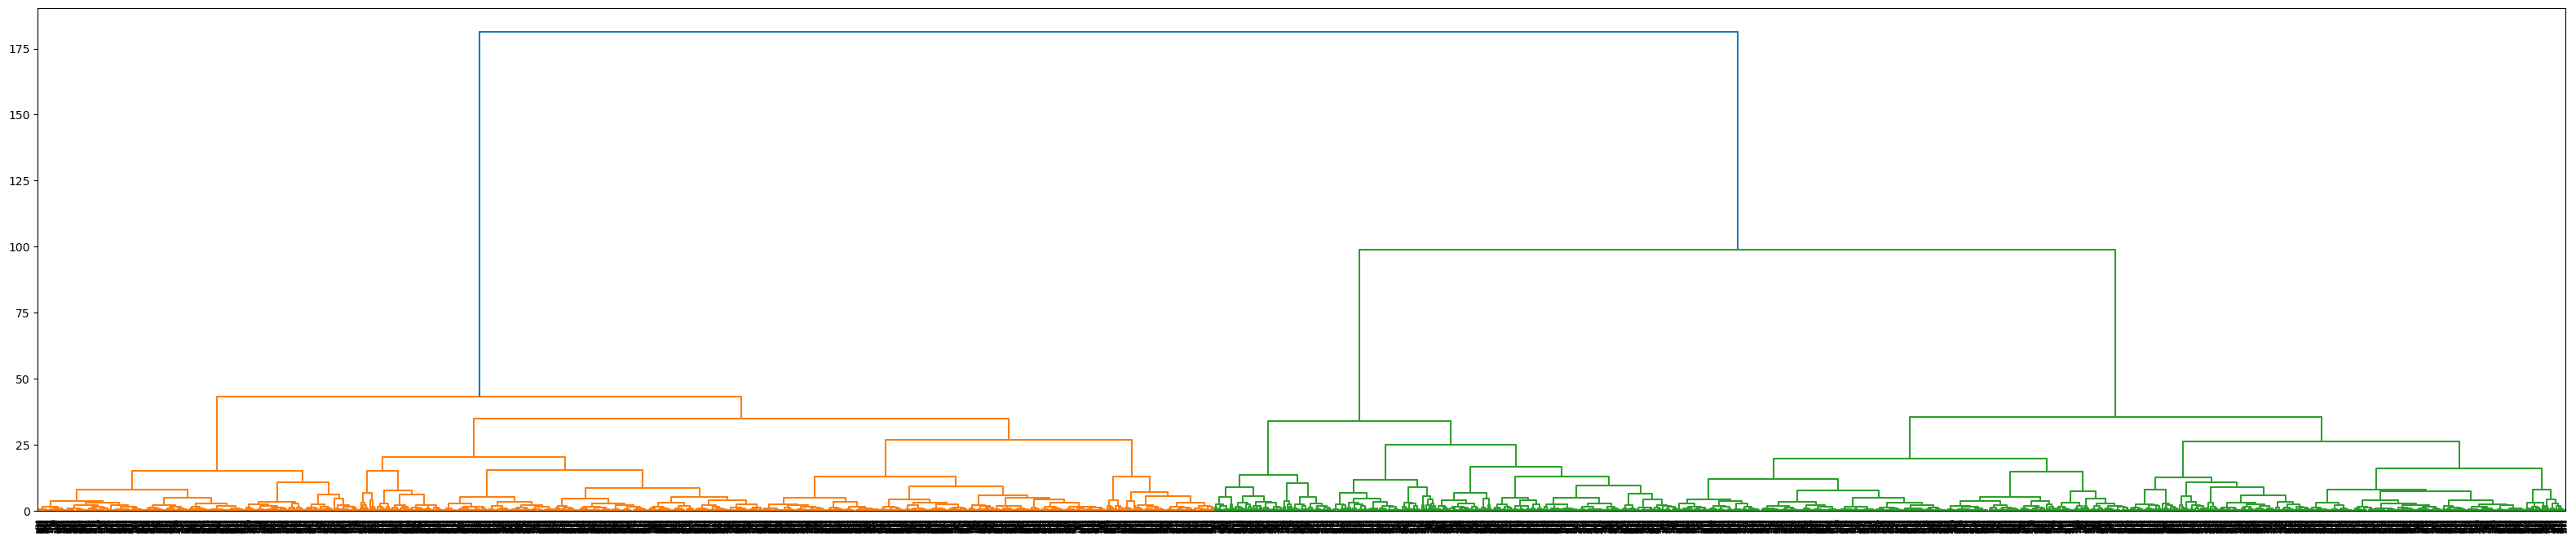

In [32]:
# Generate a dendrogram
plt.figure(figsize=(40,8))

dendrogram(hierarchical,
          leaf_rotation=90,
          leaf_font_size=5)

plt.show()

## iii.	DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [33]:
# Create DBSCAN object
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(emission_data_pca)

## iv.	Gaussian Mixture Models (GMM)

In [34]:
# Create GMM object
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_labels = gmm.fit_predict(emission_data_pca)

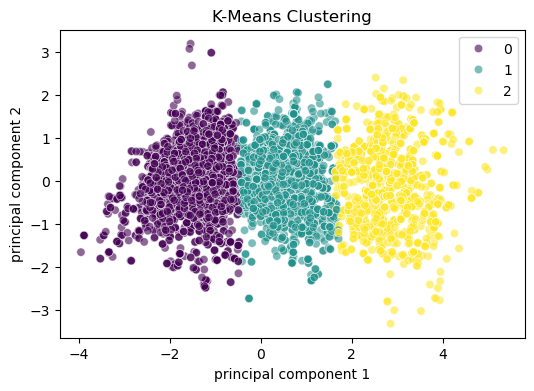

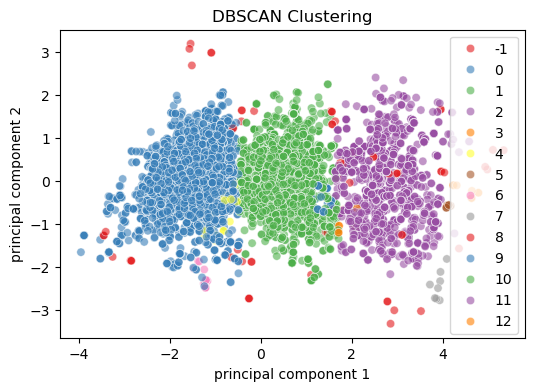

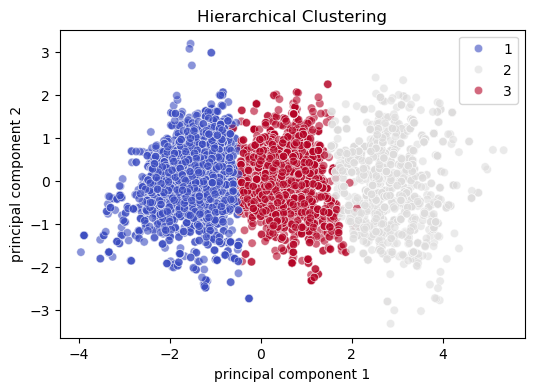

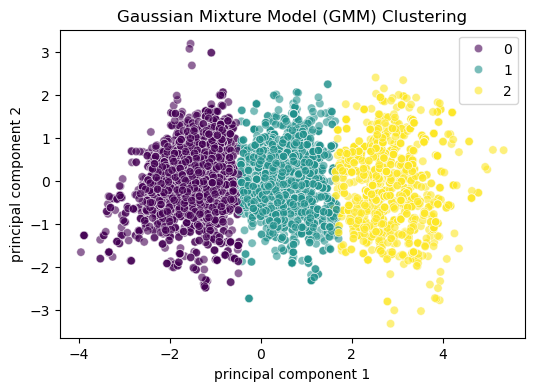

In [35]:
# Visualizing Clustering Results

# K-Means Visualization
plt.figure(figsize=(6,4))
sns.scatterplot(x=emission_data_pca.iloc[:, 0], y=emission_data_pca.iloc[:, 1], hue=predictions, palette='viridis', alpha=0.6)
plt.title("K-Means Clustering")
plt.show()


# DBSCAN Visualization
plt.figure(figsize=(6,4))
sns.scatterplot(x=emission_data_pca.iloc[:, 0], y=emission_data_pca.iloc[:, 1], hue=dbscan_labels, palette='Set1', alpha=0.6)
plt.title("DBSCAN Clustering")
plt.show()

# Hierarchical Clustering Visualization 
plt.figure(figsize=(6,4))
sns.scatterplot(x=emission_data_pca.iloc[:, 0], y=emission_data_pca.iloc[:, 1], hue=hierarchical_labels, palette='coolwarm', alpha=0.6)
plt.title("Hierarchical Clustering")
plt.show()

# GMM Visualization
plt.figure(figsize=(6,4))
sns.scatterplot(x=emission_data_pca.iloc[:, 0], y=emission_data_pca.iloc[:, 1], hue=gmm_labels, palette='viridis', alpha=0.6)
plt.title("Gaussian Mixture Model (GMM) Clustering")
plt.show()


In [36]:
# Evaluate Models
def evaluate_clustering(data, labels, model_name):
    silhouette = silhouette_score(data, labels) if len(set(labels)) > 1 else -1
    db_index = davies_bouldin_score(data, labels) if len(set(labels)) > 1 else np.inf
    return {"Model": model_name, "Silhouette Score": silhouette, "Davies-Bouldin Index": db_index}

results = [
    evaluate_clustering(emission_data_pca, predictions, "K-Means"),
    evaluate_clustering(emission_data_pca, hierarchical_labels, "Hierarchical"),
    evaluate_clustering(emission_data_pca, dbscan_labels, "DBSCAN"),
    evaluate_clustering(emission_data_pca, gmm_labels, "GMM")
]

results_df = pd.DataFrame(results)
print(results_df)

          Model  Silhouette Score  Davies-Bouldin Index
0       K-Means          0.492071              0.773817
1  Hierarchical          0.489929              0.777846
2        DBSCAN          0.230285              2.162252
3           GMM          0.492071              0.773817


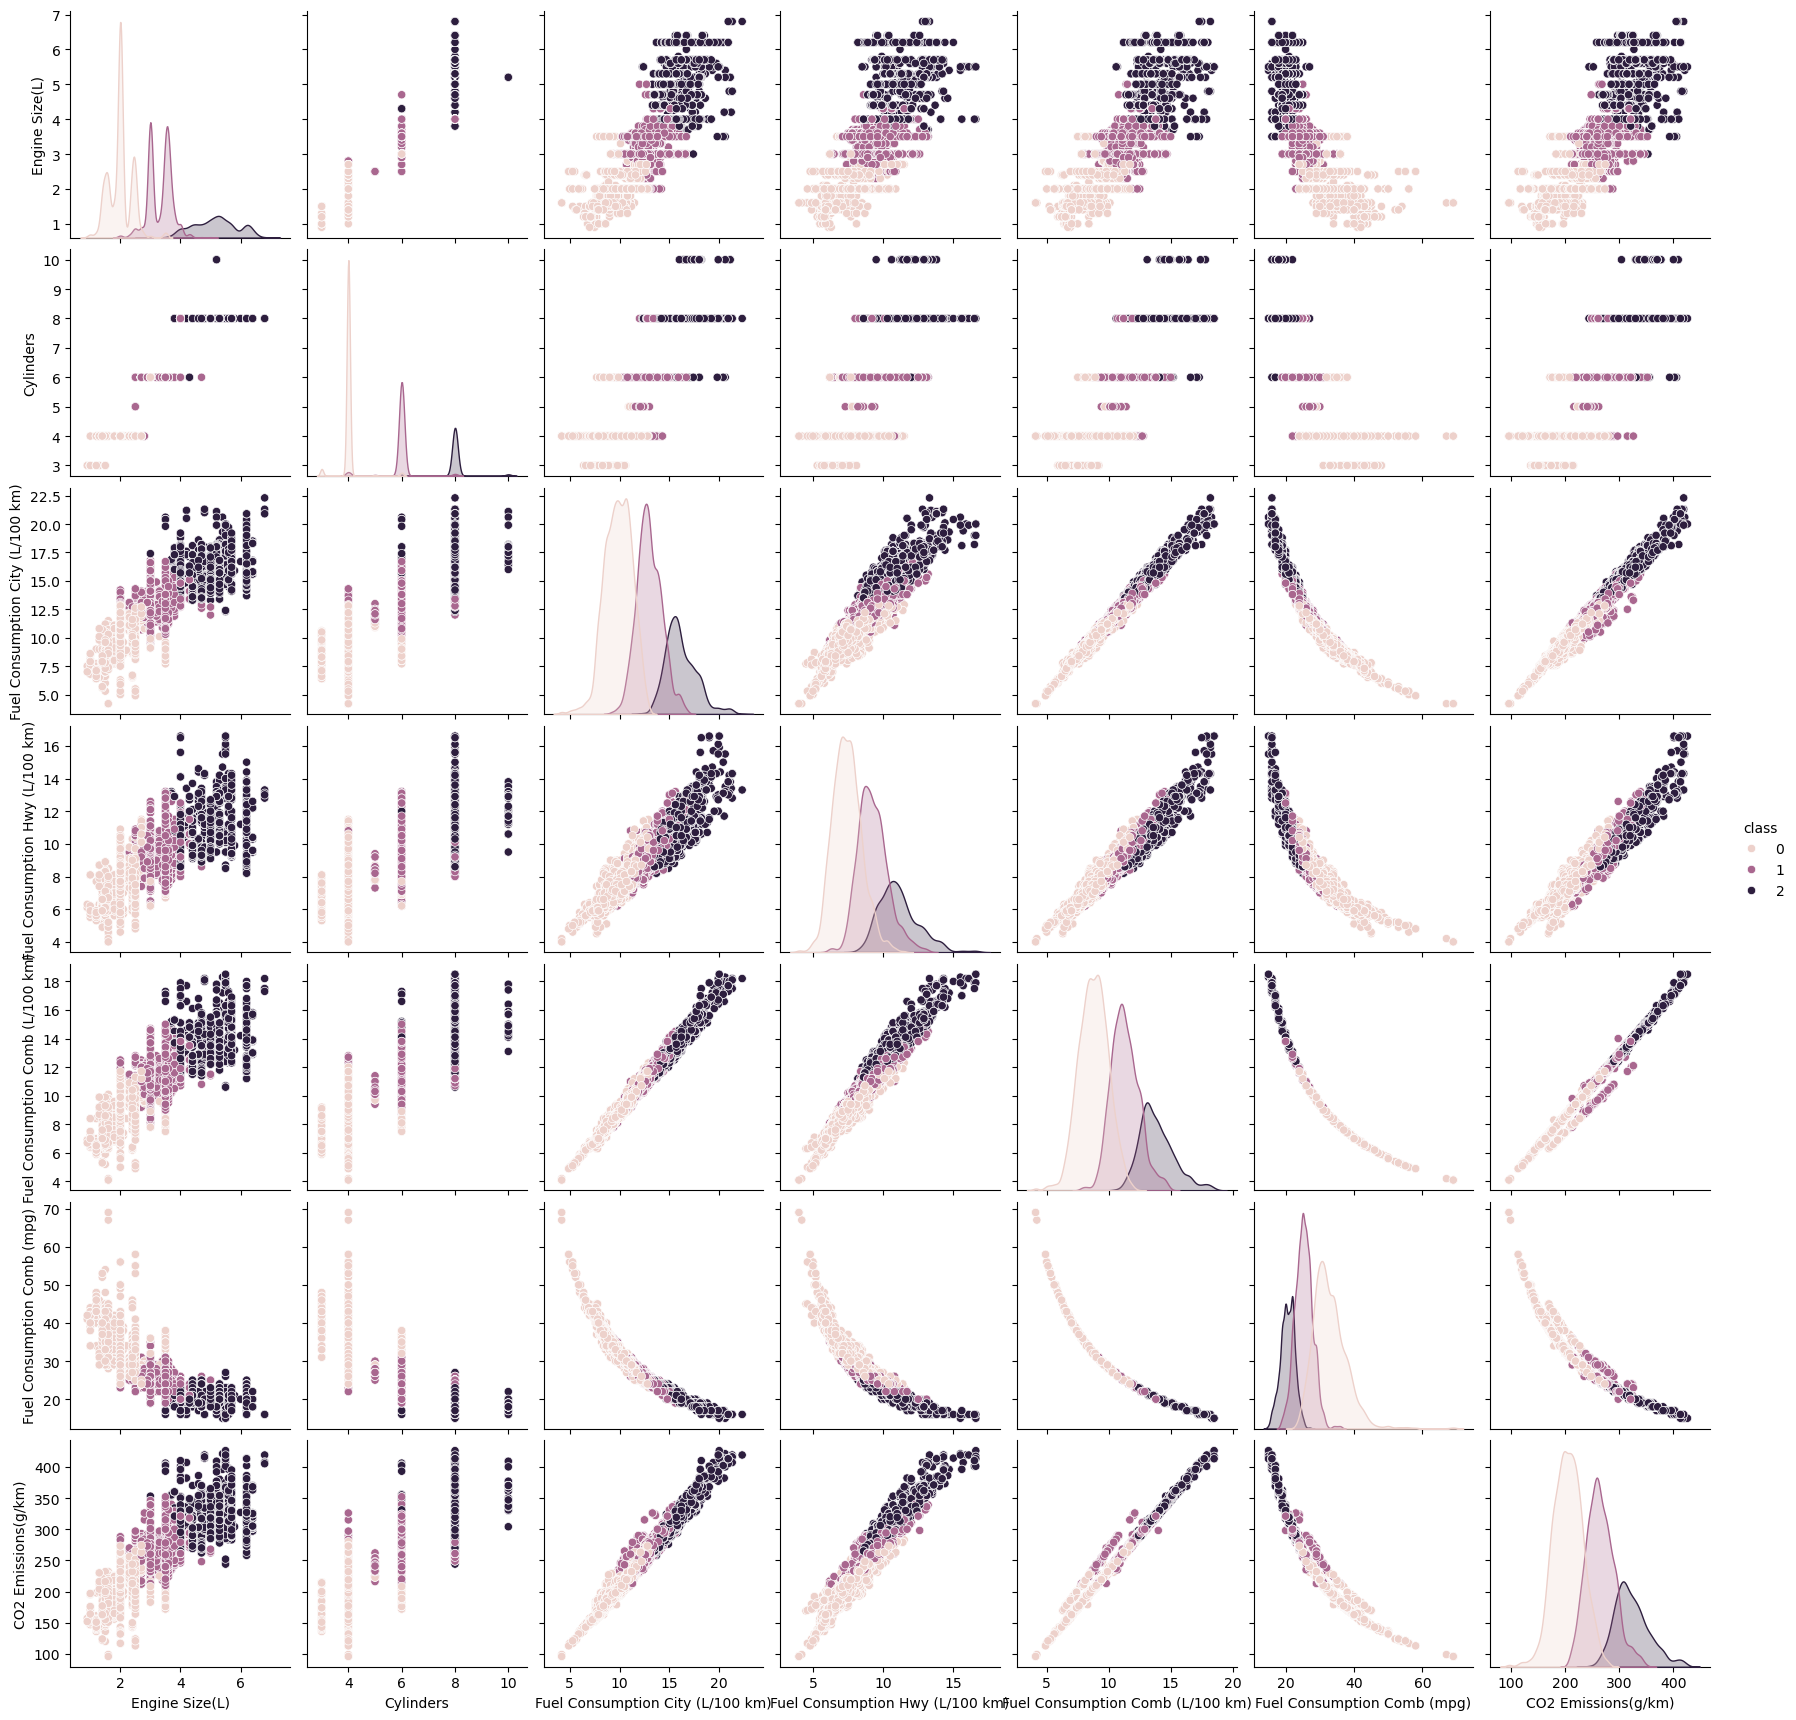

In [80]:
# Create a pair plot 
sns.pairplot(emission_df, hue='class', diag_kind='kde')
plt.show()

In [81]:
emission_df.columns

Index(['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders',
       'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)', 'class'],
      dtype='object')

In [92]:
# Add cluster labels to the dataframe
emission_df['KMeans'] = predictions
emission_df['Hierarchical'] = hierarchical_labels
emission_df['DBSCAN'] = dbscan_labels
emission_df['GMM'] = gmm_labels

# Show the head of df
emission_df.head()

Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   
2                              5.8                               5.9   
3                              9.1                              11.1   
4                              8.7                              10.6   

   Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  class  KMeans  \
0                           33                  196      0       0   
1                           29                  221      0       0   
2                           48                  136      0       0   
3                           25                  255      1       1   
4                           27                  244      1       1   

   Hierarchical  DBSCAN  GMM  
0             1       0    0  
1             1       0    0  
2             1       0    0  
3             3       1    1  
4             3       1    1

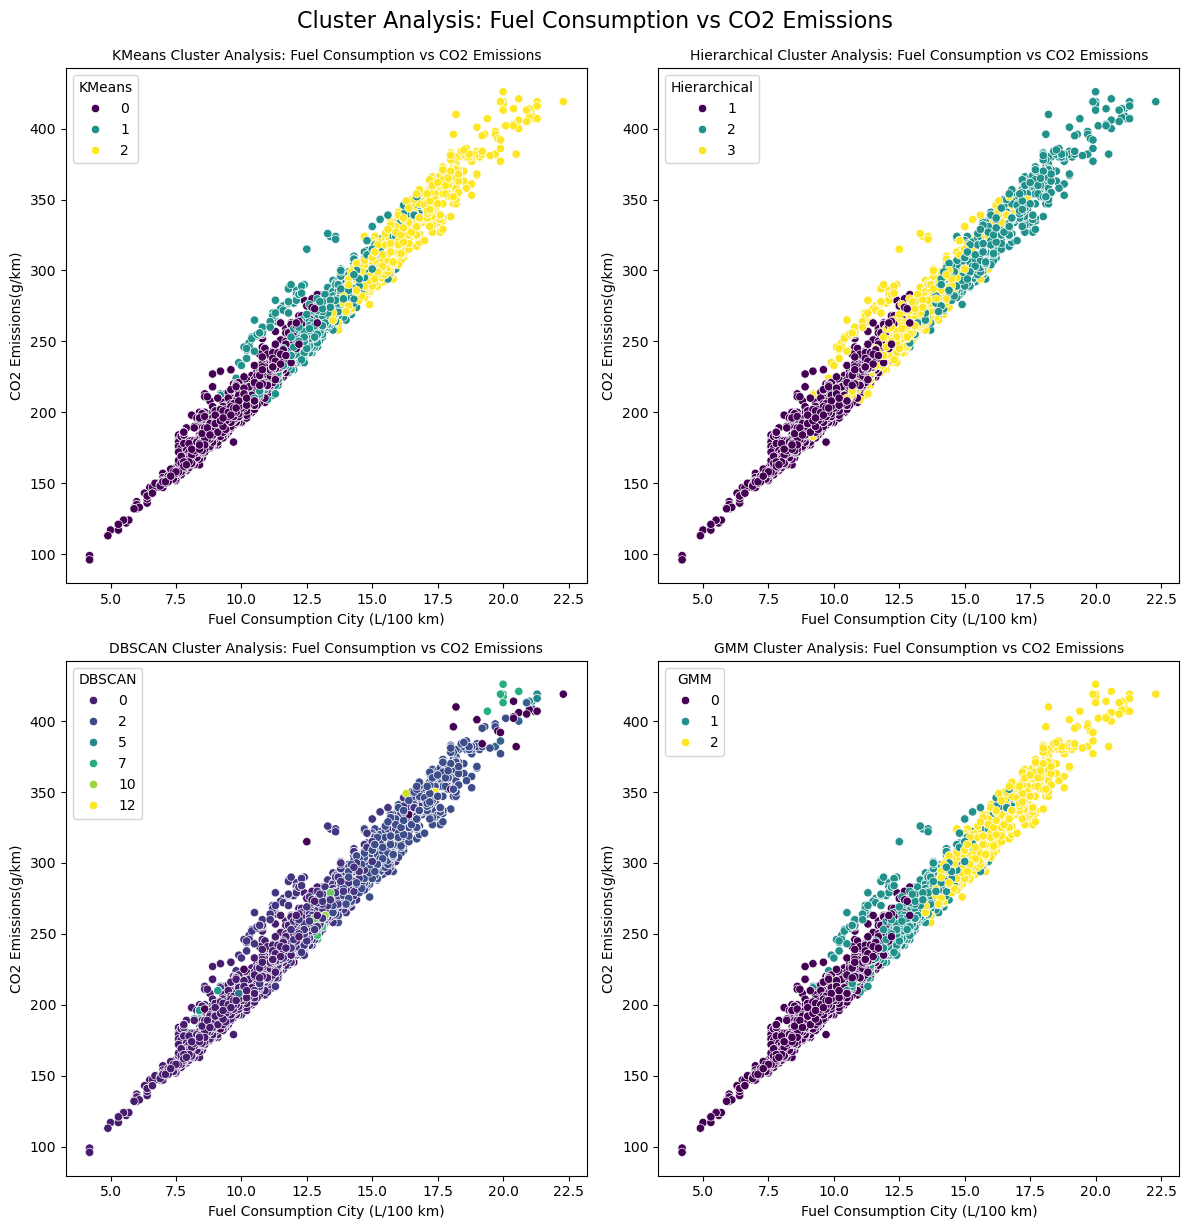

In [115]:
# Create a 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plotting KMeans cluster analysis 
sns.scatterplot(x='Fuel Consumption City (L/100 km)', y='CO2 Emissions(g/km)', 
                hue='KMeans', palette='viridis', data=emission_df, ax=axes[0, 0])
axes[0, 0].set_title("KMeans Cluster Analysis: Fuel Consumption vs CO2 Emissions", fontsize=10)

# Plotting Hierarchical cluster analysis 
sns.scatterplot(x='Fuel Consumption City (L/100 km)', y='CO2 Emissions(g/km)', 
                hue='Hierarchical', palette='viridis', data=emission_df, ax=axes[0, 1])
axes[0, 1].set_title("Hierarchical Cluster Analysis: Fuel Consumption vs CO2 Emissions", fontsize=10)

# Plotting DBSCAN cluster analysis 
sns.scatterplot(x='Fuel Consumption City (L/100 km)', y='CO2 Emissions(g/km)', 
                hue='DBSCAN', palette='viridis', data=emission_df, ax=axes[1, 0])
axes[1, 0].set_title("DBSCAN Cluster Analysis: Fuel Consumption vs CO2 Emissions", fontsize=10)

# Plotting GMM cluster analysis 
sns.scatterplot(x='Fuel Consumption City (L/100 km)', y='CO2 Emissions(g/km)', 
                hue='GMM', palette='viridis', data=emission_df, ax=axes[1, 1])
axes[1, 1].set_title("GMM Cluster Analysis: Fuel Consumption vs CO2 Emissions", fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Cluster Analysis: Fuel Consumption vs CO2 Emissions", y=1.02, fontsize=16)
plt.show()

`Interpretation:` 

The Silhouette Score measures how similar an object is to its own cluster compared to other clusters. 1  Higher scores generally indicate better-defined clusters. The Silhouette Score ranges from -1 to 1, where:

- +1: The data point is well-clustered and far from other clusters.
- 0: The data point lies on or near the decision boundary between clusters.
- -1: The data point is likely in the wrong cluster.

DBI Score and Clustering Quality
- 0 to 0.5:  Excellent clustering (well-separated, compact clusters)
- 0.5 to 1.5: Good clustering (moderate separation and compactness)
- 1.5 to 2.5: Poor clustering (overlapping, less compact clusters)
- '> 2.5: Very poor clustering (significant overlap, loose clusters)

`Result Explanation`:
* Based on the parameter mentioned above, K-Means, Hierarchial and GMM clustering models perform equally in clustering the vehicles based on their emission rate.

#### **Clustering Insights**
1. K-Means and GMM performed the best based on Silhouette Score and Davies-Bouldin Index.
2. DBSCAN struggled due to varying density in the dataset, making it less effective for vehicle emission clustering.
3. Most clusters grouped vehicles based on fuel consumption and CO2 emissions, separating high and low-emission vehicles.